Use LSTM or ARIMA

LSTM: Better with big amount of data. Is 188 million fire is enough considering that only the big ones matter and that it is on a big territory that I need to split in zone?

Seasonal ARIMA: Simpler, I could start with that.

Slide for ARIMA: https://www.slideshare.net/21_venkat/arima-26196965

This paper http://www.sciencedirect.com/science/article/pii/0925231295000208 tells that neural network outperm ARIMA for financial forecasting.

For time series all training data can be turned into supervised learning training sets. That is pick a point in time and pretend that you don't have any additional data, then produce a forecast and see how well you did. Then repeat.


My problem: Fire data are the total size burned, but at the date when the fire started. I think I can use a RNN by having a loss that consider that, so the goal is not to predict when the fire started but only the total amount burned. The model still need to put most of the fire near when the fire starts since I can cut the sequence whenever. However, I don't think there is a way to do that with ARIMA. I could also put the fire_size/duration on all the fire duration, but then I'm claiming a constant rate which is probably false.

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#from keras.models import Sequential
%matplotlib inline

from keras.models import Model
from keras.layers import GRU, concatenate, Input

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# import data
Data = np.load('Data.npy') # Shape: 4389 xy bins, 365 years, 4 input channel + 1 output. Real value
Loc = np.load('LocalizationData.npy') # Shape: 4389 xy bins, 2 channel. Integer value
#print(np.min(Loc,axis=0))
#print(np.max(Loc,axis=0))
print(Data.shape, Loc.shape)

# Normalize data for each xy bin (axis=0)
# loc must be between 0 and 1. Right now, it's between 1-135 in x and 2-57 in y, all are integers.
Loc0 = Loc - np.min(Loc,axis=0)
Loc0 = Loc0 / np.max(Loc0,axis=0) # [np.newaxis,:]
# Data[:4] must have zero mean, 1 variance
Data0 = Data[:,:,:4] - np.mean(Data[:,:,:4], axis=0) # [np.newaxis,:,:]
Data0 /= np.std(Data0, axis=0)
# We don't want to modify target
print(Data0.shape, Loc0.shape)

from sklearn.model_selection import train_test_split
# split into train, valid, test
Data0, x_test, Loc0, Loc_test, y0, y_test = train_test_split(Data0, Loc0, Data[:,:,4], test_size=0.2, random_state = 1)
# Use random_state = 1 so that the test data be always the same every time I run this notebook so that I never use it.
# I still want to suffle since the order of the data is related to the position.
x_train, x_valid, Loc_train, Loc_valid, y_train, y_valid = train_test_split(Data0, Loc0, y0, test_size=0.2)

print(x_train.shape, x_valid.shape, x_test.shape, Loc_train.shape, Loc_valid.shape,
      Loc_test.shape, y_train.shape, y_valid.shape, y_test.shape)

# Test should be used only at the end.

(4389, 365, 5) (4389, 2)
(4389, 365, 4) (4389, 2)
(2808, 365, 4) (703, 365, 4) (878, 365, 4) (2808, 2) (703, 2) (878, 2) (2808, 365) (703, 365) (878, 365)


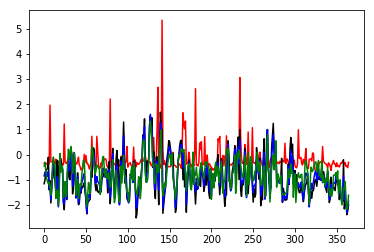

[-0.3431127  -0.30418683 -0.35062563 -0.35386624 -0.42838131 -0.41468789
 -0.34853553  1.96181955 -0.29479569 -0.2868935 ]
[ 0.44776119  0.10909091]


In [64]:
plt.plot(range(0,365),x_train[0,:,0],'r')
plt.plot(range(0,365),x_train[0,:,1],'k')
plt.plot(range(0,365),x_train[0,:,2],'b')
plt.plot(range(0,365),x_train[0,:,3],'g')
plt.show()

print(x_train[0,0:10,0])

print(Loc_train[0,:])

My thoughts:

The hidden state should be how it is easy for the place to catch fire. LSTM might not be best for that; they are best for natural language in which they serve as counter which can be incremented by a number between -1 and 1 and have a forget gate that can easily put them to zero. For me, there is no need of a forget gate, it could be the identity since the risk of fire should not go to zero easily. I could have a RELU because the risk can't be negative.

Though in fact, a forget gate can be useful when a fire is produced, since it will reduce the probability to have a fire at the same place. It depends how I ask the output to be though, since it will be very hard to predict the fire every day. If I average monthly for the fire, the forget gate might be useless.

For the truncated backpropagation through time, I could use year long step.

I'm using only the date of start of the fire, but the size of the fire depends also of the condition afterwards. Also, I will probably not be able to get the exact date of start of fire. Fire as spaced in time. So the loss should probably be computed by comparing Target with all the Output until we get a new non-zero Target. The first target should be zero, but then we should change target only when there is a fire (so it's non-zero).

Using global information could be useful since it can give information about wind and some interaction between places about fire risk, but it will be hard to add without being computationnally intensive. Also, my xy bins are not optimized for that.

I need to give information to the RNN about the location, since the location is an important risk of fire. It can be by the value of the initial hidden state, but it might need to come back more often to avoid it being washed away after some time. Also it won't be trained by truncated backpropagation through time, so if I'm using that, I probably need to input the location at each timestep. I could use a LSTM like unit in which the forget gate bring the cell state to an initial state that varies with the location rather than being 0.

I could maybe separare localization in time and fire size and give a loss for both of them.

In [3]:
from keras import backend as K

# Error: I can loop in timestep because the number of timesteps in a RNN is unknown.
# def custom_loss(y_true, y_pred):
#     loss = 0
#     target = 0
#     acc_pred = 0
    
#     # tf.unstack : convert tensor into list of tensors.
#     ytrue = tf.unstack(y_true, axis=1) # the time dimension
#     ypred = tf.unstack(y_pred, axis=1) # the time dimension
    
#     for timestep in range(len(y_true)):
#         if ytrue[timestep] != 0:
#             loss += K.square(acc_pred-target) # Compute loss for previous target
#             target = ytrue[timestep] # Change target
#             acc_pred = 0 # Put acc_pred back to zero
        
#         acc_pred += ypred[timestep] # Accumulate y_pred
#     return loss

def custom_loss(y_true, y_pred):
    return tf.reduce_mean(K.square(tf.reduce_sum(y_true,axis=1)-tf.reduce_sum(y_pred,axis=1)))
    # Sum on axis=1 the time. So that we don't care if the model predict exactly when is the fire since anyway the time is just 
    #the start
    
    # Mean at the end so that the loss doesn't change with batch_size.
    
    # It's a mean square error loss, but with a sum on time beforehand.

I am planning to input at each timestep information about the position. I can add this to x_train, x_valid, x_test at timestep 0. But then use Keras API to integrate it separately.

In [4]:
# Do my own layer for localization
from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf

class MyLayer(Layer):

    def __init__(self, output_dim, num_embedding, **kwargs):
        self.output_dim = output_dim
        self.num_embedding = num_embedding
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.embeddingsX = self.add_weight(name='embeddingsX', 
                                      shape=(self.num_embedding*2, 
                                             # Y is twice smaller than X, so it make sense to have less different vectors
                                             # I pick the number for Y and multiply it by 2 for X.
                                             self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        self.embeddingsY = self.add_weight(name='embeddingsY', 
                                      shape=(self.num_embedding, 
                                             self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)

    def call(self, x): # x is a batch_size X 2 tensor
        # x starts normalized at [0,1]
        x = x*self.num_embedding # I want it to be normalized to [0,num_embedding]
        # tf.slice(x, begin, size)  begin is the 1st element (example [0,0]), size is the final size but -1 means total size
        # for this dimension.
        # I chose than X would have num_embedding twice bigger than Y which is the written one. So I need to have *2
        X = tf.slice(x, [0, 0], [-1, 1])*2
        Y = tf.slice(x, [0, 1], [-1, 1])
        aX = tf.mod(X,1)
        aY = tf.mod(Y,1)
        #print('X',X)
        #print('Y',Y)
        #print('aX',aX)
        #print('aY',aY)
        #print(tf.reshape(K.gather(self.embeddingsX, tf.cast(tf.floor(X),tf.int32)),shape=[-1,self.output_dim]))
        out = ((1-aX)*tf.reshape(K.gather(self.embeddingsX, tf.cast(tf.floor(X),tf.int32)),shape=[-1,self.output_dim]) + 
               aX*tf.reshape(K.gather(self.embeddingsX, tf.cast(tf.ceil(X),tf.int32)),shape=[-1,self.output_dim]) +
               (1-aY)*tf.reshape(K.gather(self.embeddingsY, tf.cast(tf.floor(Y),tf.int32)),shape=[-1,self.output_dim]) +
               aY*tf.reshape(K.gather(self.embeddingsY, tf.cast(tf.ceil(Y),tf.int32)),shape=[-1,self.output_dim]))
        # gather(tensor, indices, axis). Indices can be a scalar or a vector.
        # It gathers element on specified axis. All other axis pass through.
        # By default it's on axis=0 which is the one with a dim of 
        # num_embeddig
        return out

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [5]:
# Print function for debugging
# from https://stackoverflow.com/questions/37898478/is-there-a-way-to-get-tensorflow-tf-print-output-to-appear-in-jupyter-notebook-o

# However, it seems it works only by directly using tensorflow not keras.

def tf_print(tensor, transform=None):

    # Insert a custom python operation into the graph that does nothing but print a tensors value 
    def print_tensor(x):
        # x is typically a numpy array here so you could do anything you want with it,
        # but adding a transformation of some kind usually makes the output more digestible
        print(x if transform is None else transform(x))
        return x
    log_op = tf.py_func(print_tensor, [tensor], [tensor.dtype])[0]
    with tf.control_dependencies([log_op]):
        res = tf.identity(tensor)

    # Return the given tensor
    return res

import numpy as np # to use np.mean in transform


# Keras printing layer

class PrintLayer(Layer):
    def __init__(self, **kwargs):
        super(PrintLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(PrintLayer, self).build(input_shape)

    def call(self, x): 
        return tf_print(x, np.mean)

    def compute_output_shape(self, input_shape):
        return input_shape

In [6]:
# Reshape y
Y_train = y_train.reshape((-1,365,1))
Y_valid = y_valid.reshape((-1,365,1))
# Y_test = y_test.reshape((-1,365,1))

# I think it's needed to correct error: 
# ValueError: Cannot feed value of shape (32, 365) for Tensor 'gru_3_target:0', which has shape '(?, ?, ?)'

In [7]:
nUnits = 5
ntimesteps = 365

from keras.layers import RepeatVector

# https://keras.io/getting-started/functional-api-guide/

main_input = Input(shape=(ntimesteps,4))
auxiliary_input = Input(shape=(2,))
# Need to embed the localisation in a tensor that is similar to close tensor 
# since we want to use the training data for the validation and test data
# which are at different position (but most likely have similar risk than
# the nearby positions)
# It might be better to use many years and use the last few years as validation
# and test.
loc_layer = MyLayer(5, 25)(auxiliary_input) # output_dim, num_embeddings
# !!!!!!!!!!!!!!!!!!!! ERROR HERE !!!!!!!!!!!!!!!!!!!!!!!
print('main_input',main_input)
print('auxiliary_input',auxiliary_input)
print('loc_layer',loc_layer)
time_loc_layer = RepeatVector(ntimesteps)(loc_layer)
print('time_loc_layer',time_loc_layer)
x = concatenate([main_input, time_loc_layer]) # By default, concatenate on the last axis
x = GRU(nUnits, return_sequences=True)(x) 
# By default, it's data_format='channels_last' which is what we want.
print('1st GRU',x)
#x = PrintLayer()(x) Doesn't work
x = GRU(1, return_sequences=True)(x)
print('2nd GRU',x)

model = Model(inputs=[main_input, auxiliary_input], outputs=x)

model.compile(optimizer='adam',
              loss=custom_loss)

callbacks = [EarlyStopping(monitor='val_loss', min_delta=0., patience=10)]

for batchsize in [1,2,4]:
    print('_'*20)
    print('')
    print(batchsize)
    print('')
    model.fit([x_train, Loc_train], Y_train, epochs=1, batch_size=batchsize,verbose=2,callbacks=callbacks,shuffle=True, 
              validation_data=([x_valid, Loc_valid], Y_valid))

main_input Tensor("input_1:0", shape=(?, 365, 4), dtype=float32)
auxiliary_input Tensor("input_2:0", shape=(?, 2), dtype=float32)
loc_layer Tensor("my_layer_1/add_2:0", shape=(?, 5), dtype=float32)
time_loc_layer Tensor("repeat_vector_1/Tile:0", shape=(?, 365, 5), dtype=float32)
1st GRU Tensor("gru_1/transpose_1:0", shape=(?, ?, 5), dtype=float32)
2nd GRU Tensor("gru_2/transpose_1:0", shape=(?, ?, 1), dtype=float32)
____________________

1

Train on 2808 samples, validate on 703 samples
Epoch 1/1


InternalError: Blas GEMM launch failed : a.shape=(365, 9), b.shape=(9, 5), m=365, n=5, k=9
	 [[Node: gru_1/MatMul_2 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](gru_1/Reshape_4, gru_1/strided_slice_4)]]
	 [[Node: mul_1/_67 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3814_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'gru_1/MatMul_2', defined at:
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-b936ae9c3a73>", line 24, in <module>
    x = GRU(nUnits, return_sequences=True)(x)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\keras\layers\recurrent.py", line 262, in __call__
    return super(Recurrent, self).__call__(inputs, **kwargs)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\keras\engine\topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\keras\layers\recurrent.py", line 333, in call
    preprocessed_input = self.preprocess_input(inputs, training=None)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\keras\layers\recurrent.py", line 791, in preprocess_input
    timesteps, training=training)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\keras\layers\recurrent.py", line 50, in _time_distributed_dense
    x = K.dot(x, w)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\keras\backend\tensorflow_backend.py", line 978, in dot
    out = tf.matmul(x, y)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1816, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 1217, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\nicol\Anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(365, 9), b.shape=(9, 5), m=365, n=5, k=9
	 [[Node: gru_1/MatMul_2 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](gru_1/Reshape_4, gru_1/strided_slice_4)]]
	 [[Node: mul_1/_67 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_3814_mul_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [8]:
for batchsize in [32, 64, 128, 256]:
    model.fit([x_train, Loc_train], y_train, epochs=1, batch_size=batchsize,verbose=2,shuffle=True)

Epoch 1/1


ValueError: Cannot feed value of shape (32, 365) for Tensor 'gru_3_target:0', which has shape '(?, ?, ?)'